# Install & Import Dependencies

In [1]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate
!pip install evaluate
!pip install scikit-learn
!pip install bert-score
!pip install sacrebleu
!pip install sentencepiece

In [2]:
import torch
import transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sentencepiece
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from wordcloud import WordCloud
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import load_dataset, load_metric
from sacrebleu.metrics import BLEU, CHRF, TER
from bert_score import score as bert_score
from nltk.translate.meteor_score import meteor_score

# Load Datasets

In [3]:
nusax_mt = load_dataset("indonlp/NusaX-MT")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for indonlp/NusaX-MT contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/indonlp/NusaX-MT
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnin

In [4]:
nusax_sun_eng = load_dataset("indonlp/NusaX-MT", name='sun-eng')

# Exploratory Datasets Analysis

In [5]:
nusax_sun_eng

DatasetDict({
    train: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 100
    })
    test: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 400
    })
})

In [6]:
nusax_mt

DatasetDict({
    train: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 66000
    })
    validation: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 13200
    })
    test: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 52800
    })
})

In [7]:
nusax_mt_df_train = nusax_mt['train'].to_pandas()
nusax_mt_df_test = nusax_mt['test'].to_pandas()
nusax_mt_df_valid = nusax_mt['validation'].to_pandas()

nusax_sun_eng_df_train = nusax_sun_eng['train'].to_pandas()
nusax_sun_eng_df_test = nusax_sun_eng['test'].to_pandas()
nusax_sun_eng_df_valid = nusax_sun_eng['validation'].to_pandas()

In [8]:
display(nusax_mt_df_train)
display(nusax_sun_eng_df_train)

,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Neumeuseunang ngon neubayeue bacut-bacut angsu...,Nikmati cicilan 0% kanti 12 bulan antuk pemesa...,ace,ban
1,1,Kueh nyang dihidang peuingat lon masa dilee. B...,Jaje-jaje ne sane kasajiang ngaenang tiang ber...,ace,ban
2,2,Ibu tom geukereuja bak Grab Indonesia,Ibu naenang makarya ring grab Indonesia,ace,ban
3,3,"Paleng galak ta pajoh bu leuho inoe, manok ngo...",Paling demen sajan ngajeng siang driki be siap...,ace,ban
4,4,Peulayanan bus DAMRI cukop get,Pelayanan bus DAMRI luung pesan.,ace,ban
...,...,...,...,...,...
65995,65995,Si A pangkataionna tong kosong nyaring bunyina...,Si A nyarita tong kosong heuras bunyina bicara...,bbc,sun
65996,65996,Sambalna dang nahaluluan di inganan na asing. ...,Sambelna moal aya di tempat nu sanes. Rasa tar...,bbc,sun
65997,65997,"Pandapothu lumayan do hu lala steak nai, alai ...","Numutkeun abdi steakna cekap raos, mung leuwih...",bbc,sun
65998,65998,radotu sipanganon on dah gus na lagi musim na ...,Dijaganya gus tuangeunna nuju usumna ayeuna ma...,bbc,sun


,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Nikmati angsuran 0% dugi ka 12 bulan kanggo me...,Enjoy 0% instalment for up to 12 months when o...,sun,eng
1,1,Kue anu disajikeun ngajantenkeun kuring nostal...,The cakes give me massive nostalgia. Everythin...,sun,eng
2,2,Ibu kantos ngadamel di grab indonesia,Mom once worked for grab indonesia.,sun,eng
3,3,Pang resepna tuang beubeurangan di dieu hayam ...,"I love having lunch here the most, thanks to t...",sun,eng
4,4,Palayanan beus DAMRI sae pisan,The DAMRI Bus service is really good,sun,eng
...,...,...,...,...,...
495,495,Si A nyarita tong kosong heuras bunyina bicara...,A talks like empty vessels that make the most ...,sun,eng
496,496,Sambelna moal aya di tempat nu sanes. Rasa tar...,You won't find this sambal anywhere else. The ...,sun,eng
497,497,"Numutkeun abdi steakna cekap raos, mung leuwih...","I think the steak was quite good, my advice is...",sun,eng
498,498,Dijaganya gus tuangeunna nuju usumna ayeuna ma...,"Watch what you eat, Gus, it's that kind of sea...",sun,eng


### Merge Splited Datasets

In [9]:
sun_eng_df = pd.concat(
    [
        nusax_sun_eng_df_train,
        nusax_sun_eng_df_test,
        nusax_sun_eng_df_valid
        ],
    axis=0,
    ignore_index=True
    )

nusax_full_df = pd.concat(
    [
        nusax_mt_df_train,
        nusax_mt_df_test,
        nusax_mt_df_valid
        ],
    axis=0,
    ignore_index=True
    )

display(sun_eng_df)
display(nusax_full_df)

,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Nikmati angsuran 0% dugi ka 12 bulan kanggo me...,Enjoy 0% instalment for up to 12 months when o...,sun,eng
1,1,Kue anu disajikeun ngajantenkeun kuring nostal...,The cakes give me massive nostalgia. Everythin...,sun,eng
2,2,Ibu kantos ngadamel di grab indonesia,Mom once worked for grab indonesia.,sun,eng
3,3,Pang resepna tuang beubeurangan di dieu hayam ...,"I love having lunch here the most, thanks to t...",sun,eng
4,4,Palayanan beus DAMRI sae pisan,The DAMRI Bus service is really good,sun,eng
...,...,...,...,...,...
995,95,Mohon informasikeun atm mana wae di semarang n...,Please inform which ATM in Semarang can be use...,sun,eng
996,96,Rerencangan nyarankeun tempat ieu kusabab rasa...,My friend recommended this place because of it...,sun,eng
997,97,"Mimiti kuring kadieu nganggap enteng, sawaktos...","The first time coming here, I understimated th...",sun,eng
998,98,Tempatna nyenengkeun nya kanggo nu atos berkul...,The venue's fun both for people with families ...,sun,eng


,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Neumeuseunang ngon neubayeue bacut-bacut angsu...,Nikmati cicilan 0% kanti 12 bulan antuk pemesa...,ace,ban
1,1,Kueh nyang dihidang peuingat lon masa dilee. B...,Jaje-jaje ne sane kasajiang ngaenang tiang ber...,ace,ban
2,2,Ibu tom geukereuja bak Grab Indonesia,Ibu naenang makarya ring grab Indonesia,ace,ban
3,3,"Paleng galak ta pajoh bu leuho inoe, manok ngo...",Paling demen sajan ngajeng siang driki be siap...,ace,ban
4,4,Peulayanan bus DAMRI cukop get,Pelayanan bus DAMRI luung pesan.,ace,ban
...,...,...,...,...,...
131995,13195,Tolong jolo paboa atm na didia do di semarang ...,Mohon informasikeun atm mana wae di semarang n...,bbc,sun
131996,13196,Dongan mangarekomendasihon inganan on alani da...,Rerencangan nyarankeun tempat ieu kusabab rasa...,bbc,sun
131997,13197,Parjolo sahali au ro tuson dang apala lomo roh...,"Mimiti kuring kadieu nganggap enteng, sawaktos...",bbc,sun
131998,13198,"Inganan na tabo, denggan laho tu akka naung ma...",Tempatna nyenengkeun nya kanggo nu atos berkul...,bbc,sun


### Sentence Length

In [10]:
sun_eng_df['text_1_length'] = sun_eng_df['text_1'].apply(lambda x: len(x.split()))
sun_eng_df['text_2_length'] = sun_eng_df['text_2'].apply(lambda x: len(x.split()))

display(sun_eng_df.describe())

,text_1_length,text_2_length
count,1000.000000,1000.000000
mean,23.098000,28.578000
std,14.290298,17.975735
min,1.000000,2.000000
25%,12.000000,15.000000
50%,19.000000,24.000000
75%,31.000000,37.250000
max,76.000000,107.000000


### Distribution

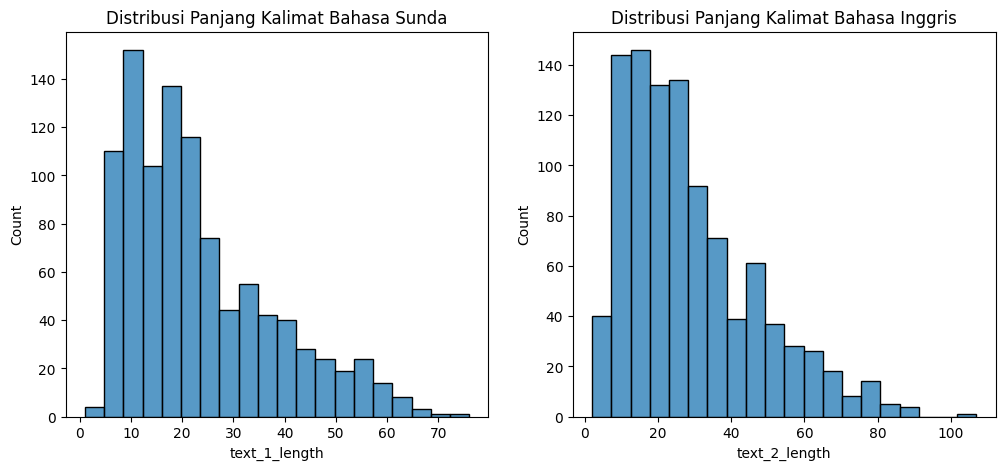

In [11]:
# analisis distribusi kata
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
sns.histplot(sun_eng_df['text_1_length'], bins=20)
plt.title('Distribusi Panjang Kalimat Bahasa Sunda')

plt.subplot(1,2,2)
sns.histplot(sun_eng_df['text_2_length'], bins=20)
plt.title('Distribusi Panjang Kalimat Bahasa Inggris')

plt.show()


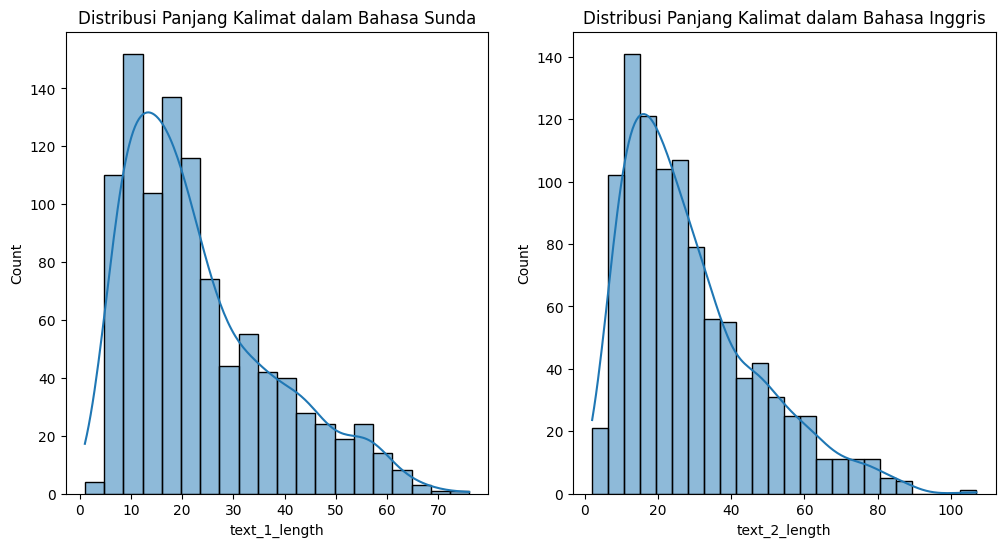

In [12]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.histplot(sun_eng_df['text_1_length'], kde=True)
plt.title('Distribusi Panjang Kalimat dalam Bahasa Sunda')

plt.subplot(1,2,2)
sns.histplot(sun_eng_df['text_2_length'], kde=True)
plt.title('Distribusi Panjang Kalimat dalam Bahasa Inggris')

plt.show()


### Most Common Words

In [13]:
# kata kata paling umum
def get_most_common_words(series, n_most_common=10):
    counter = Counter()
    for sentence in series:
        counter.update(sentence.lower().split())
    return counter.most_common(n_most_common)

print("Kata-kata Paling Umum dalam Bahasa Sunda:")
print(get_most_common_words(sun_eng_df['text_1']))

print("\nKata-kata Paling Umum dalam Bahasa Inggris:")
print(get_most_common_words(sun_eng_df['text_2']))

Kata-kata Paling Umum dalam Bahasa Sunda:
[('nu', 615), ('sareng', 542), ('di', 457), ('teu', 375), ('abdi', 314), ('ka', 247), ('aya', 216), ('anu', 214), ('kanggo', 198), ('ku', 192)]

Kata-kata Paling Umum dalam Bahasa Inggris:
[('the', 1939), ('and', 709), ('to', 613), ('is', 592), ('a', 574), ('of', 468), ('i', 380), ('for', 379), ('in', 370), ('was', 345)]


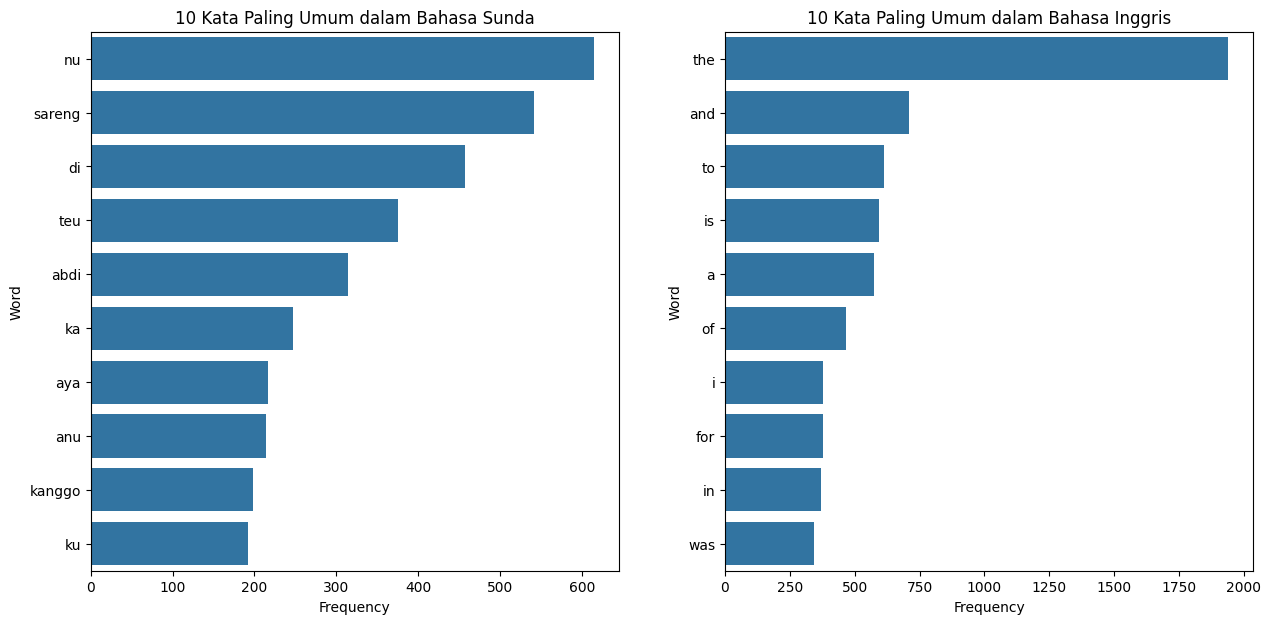

In [14]:
# Mendapatkan 10 kata teratas
top_sun_words = get_most_common_words(sun_eng_df['text_1'], 10)
top_eng_words = get_most_common_words(sun_eng_df['text_2'], 10)

# Membuat dataframe untuk visualisasi
df_vis_sun = pd.DataFrame(top_sun_words, columns=['Word', 'Frequency'])
df_vis_eng = pd.DataFrame(top_eng_words, columns=['Word', 'Frequency'])

# Visualisasi
plt.figure(figsize=(15, 7))
plt.subplot(1,2,1)
sns.barplot(x='Frequency', y='Word', data=df_vis_sun)
plt.title('10 Kata Paling Umum dalam Bahasa Sunda')

plt.subplot(1,2,2)
sns.barplot(x='Frequency', y='Word', data=df_vis_eng)
plt.title('10 Kata Paling Umum dalam Bahasa Inggris')

plt.show()

### N-Gram Analysis

In [15]:
def generate_ngrams(text, n=2):
    words = text.split()
    ngrams = zip(*[words[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

# Contoh untuk bigram dalam Bahasa Sunda
sun_bigrams = generate_ngrams(" ".join(sun_eng_df['text_1']), n=2)
Counter(sun_bigrams).most_common(10)


[('di dieu', 40),
 ('tuang di', 37),
 ('teu aya', 37),
 ('ka dieu', 27),
 ('sumping ka', 27),
 ('tempat ieu', 24),
 ('tuangeun nu', 24),
 ('teu tiasa', 24),
 ('di tempat', 23),
 ('di dieu.', 21)]

In [16]:
# Contoh untuk bigram dalam Bahasa Inggris
eng_bigrams = generate_ngrams(" ".join(sun_eng_df['text_2']), n=2)
Counter(eng_bigrams).most_common(10)

[('and the', 106),
 ('of the', 94),
 ('in the', 82),
 ('place is', 64),
 ('to the', 60),
 ('the food', 59),
 ('for the', 57),
 ('The food', 52),
 ('for a', 51),
 ('a lot', 51)]

### WordClouds

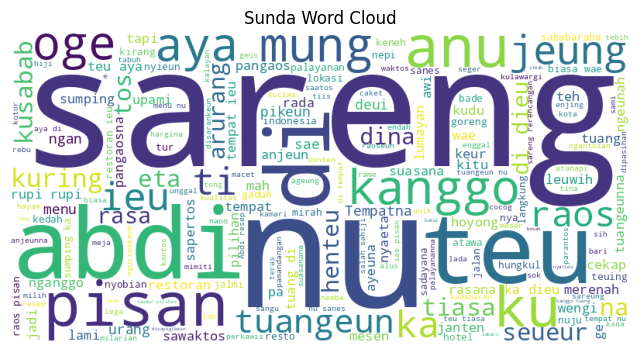

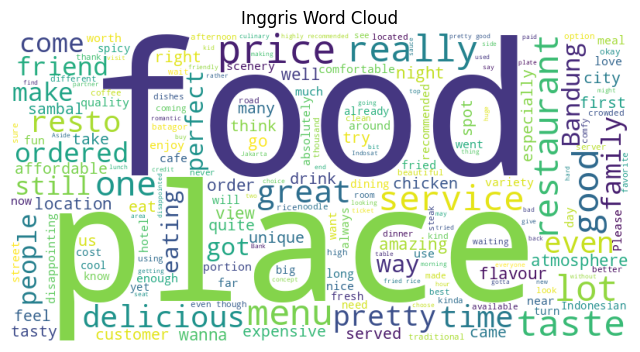

In [17]:
def plot_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(" ".join(text))
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_word_cloud(sun_eng_df['text_1'], 'Sunda Word Cloud')
plot_word_cloud(sun_eng_df['text_2'], 'Inggris Word Cloud')


# Text Preprocessing


# Datasets Preprocessing

In [18]:
source_lang = 'sun'
target_lang = 'eng'

In [19]:
train_sun_eng_df = pd.concat(
    [
        nusax_sun_eng_df_train,
        nusax_sun_eng_df_test,
        ],
    axis=0,
    ignore_index=True
    )

display(train_sun_eng_df)

,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Nikmati angsuran 0% dugi ka 12 bulan kanggo me...,Enjoy 0% instalment for up to 12 months when o...,sun,eng
1,1,Kue anu disajikeun ngajantenkeun kuring nostal...,The cakes give me massive nostalgia. Everythin...,sun,eng
2,2,Ibu kantos ngadamel di grab indonesia,Mom once worked for grab indonesia.,sun,eng
3,3,Pang resepna tuang beubeurangan di dieu hayam ...,"I love having lunch here the most, thanks to t...",sun,eng
4,4,Palayanan beus DAMRI sae pisan,The DAMRI Bus service is really good,sun,eng
...,...,...,...,...,...
895,395,Kuring geus mindeng datang ngarasakeun kadahar...,I've been coming to enjoy the food in Roemah N...,sun,eng
896,396,Seueur jalmi kirang reseup berobat ka dokter. ...,A lot of people don't really like going to the...,sun,eng
897,397,"Palayananna sae, tempat parkirna lega, kebon s...","Good service, large enough parking lot, the st...",sun,eng
898,398,"Demi naon wae tes cpns ngajieun macet, sialann...","For crying out loud, CPNS test caused traffic,...",sun,eng


In [20]:
from datasets import Dataset as DatasetHF

nusax_SunEng = DatasetHF.from_pandas(train_sun_eng_df)

display(nusax_SunEng)

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
    num_rows: 900
})

In [21]:
class TranslationDataset(Dataset):
    def __init__(self, tokenizer, texts, targets, max_length=512):
        self.tokenizer = tokenizer
        self.texts = texts
        self.targets = targets
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        source = self.texts[idx]
        target = self.targets[idx]

        source_tokenized = self.tokenizer(
            source, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt'
        )
        target_tokenized = self.tokenizer(
            target, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt'
        )

        return {
            'input_ids': source_tokenized['input_ids'].flatten(),
            'attention_mask': source_tokenized['attention_mask'].flatten(),
            'labels': target_tokenized['input_ids'].flatten()
        }


tokenizer = T5Tokenizer.from_pretrained('t5-small')
train_dataset = TranslationDataset(tokenizer, nusax_SunEng['text_1'], nusax_SunEng['text_2'])
val_dataset = TranslationDataset(tokenizer, nusax_sun_eng['validation']['text_1'], nusax_sun_eng['validation']['text_2'])

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Training Loop

In [22]:
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.cuda.amp import GradScaler, autocast

In [23]:
torch.cuda.empty_cache()

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = T5ForConditionalGeneration.from_pretrained("t5-small").to(device) # the model

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True) # dataloader for train
val_loader = DataLoader(val_dataset, batch_size=4) # dataloader for validation

optimizer = AdamW(model.parameters(), lr=5e-5) # the optimizer
num_epochs = 3 # num epochs
num_training_steps = num_epochs * len(train_loader) # training steps
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps) # learning rate scheduler

train_losses, val_losses = [], [] # a variable to store training history

accumulation_steps = 2
scaler = GradScaler()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    # for batch in train_loader:
    for step, batch in enumerate(train_loader):
        optimizer.zero_grad()

        # with autocast():
        #     input_ids = batch["input_ids"].to(device)
        #     attention_mask = batch["attention_mask"].to(device)
        #     labels = batch["labels"].to(device)
        #     outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        #     loss = outputs.loss

        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()
        # lr_scheduler.step()

        # train_loss += loss.item()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()

        loss.backward()
        # optimizer.step()
        # lr_scheduler.step()
        if (step + 1) % accumulation_steps == 0:
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} Train Loss: {avg_train_loss}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss}")



/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 Train Loss: 2.981033285193973
Epoch 1 Validation Loss: 0.39513983607292175
Epoch 2 Train Loss: 0.6339863267209794
Epoch 2 Validation Loss: 0.38399928987026216
Epoch 3 Train Loss: 0.48981272578239443
Epoch 3 Validation Loss: 0.36203978180885316


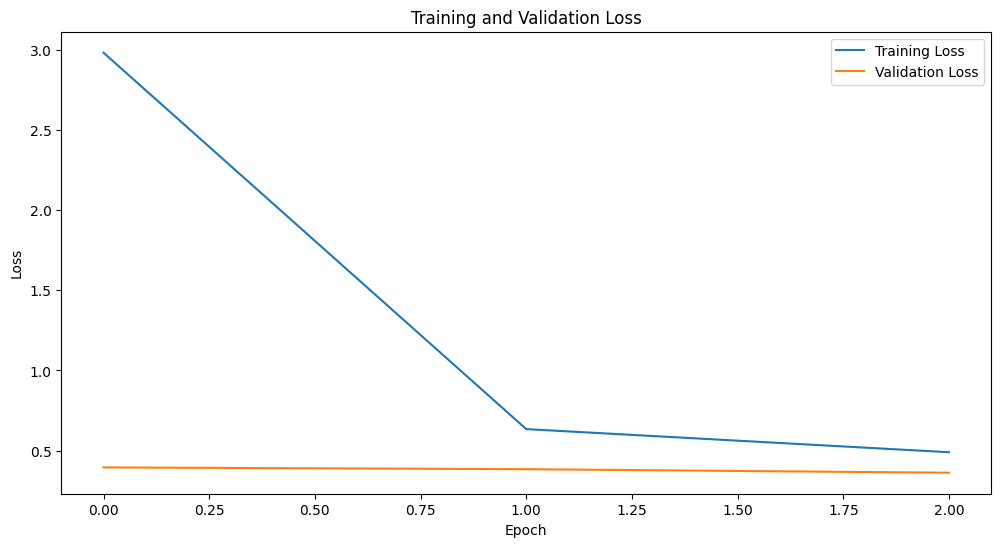

In [25]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
model.save_pretrained("t5_nusax_sun_eng")

# Evaluation with Custom Metrics
Here, we include BLEU, METEOR, and BERTScore for evaluation. Custom metrics can be added similarly.

In [27]:
from tqdm import tqdm

bleu_metric = load_metric("sacrebleu")
meteor_metric = load_metric("meteor")
bertscore_metric = load_metric("bertscore")

<ipython-input-27-bb2afe1c18ff>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for sacrebleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/sacrebleu/sacrebleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for meteor contains custom code which must be executed to correctly load the metric. You can inspect

In [28]:
# load pretrained model
model_pt = T5ForConditionalGeneration.from_pretrained("t5_nusax_sun_eng")
model_pt.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [29]:
def evaluate(model_pt, dataloader, tokenizer, device):
    model_pt.eval()
    bleu_metric = load_metric("sacrebleu")
    meteor_metric = load_metric("meteor")
    bertscore_metric = load_metric("bertscore")

    bleu_scores, meteor_scores, bert_scores = [], [], []

    for batch in tqdm(dataloader, desc="Evaluating"):
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        # print("\n")
        # print("-"*50)
        # print("input-ids   :", input_ids)
        # print("labels  :", labels)

        with torch.no_grad():
          outputs = model_pt.generate(input_ids)
        # outputs = model.generate(input_ids)
        # print("outputs :", outputs)

        preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in outputs]
        input_ids = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in input_ids]
        labels = [tokenizer.decode(l, skip_special_tokens=True, clean_up_tokenization_spaces=True) for l in labels]
        print("\n")
        print("-"*50)
        print("Preds   :", preds)
        print("labels  :", labels)
        print("input-ids   :", input_ids)

        bleu_scores.append(bleu_metric.compute(predictions=preds, references=[[l] for l in labels])["score"])

        # Check METEOR output
        meteor_output = meteor_metric.compute(predictions=preds, references=labels)
        meteor_scores.append(meteor_output["meteor"])

        # Extract METEOR score based on its actual structure
        # Replace the next line with the correct way to extract the METEOR score
        # meteor_scores.append(meteor_output["score"])

        bert_scores.append(bertscore_metric.compute(predictions=preds, references=labels, lang="en")["f1"][0])

    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    avg_meteor = sum(meteor_scores) / len(meteor_scores)
    avg_bert = sum(bert_scores) / len(bert_scores)

    return avg_bleu, avg_meteor, avg_bert

# Evaluate the model
avg_bleu, avg_meteor, avg_bert = evaluate(model_pt, val_loader, tokenizer, device)
print(f"BLEU Score: {avg_bleu}")
print(f"METEOR Score: {avg_meteor}")
print(f"BERTScore: {avg_bert}")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for sacrebleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/sacrebleu/sacrebleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for meteor contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/meteor/meteor.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric fro



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ["If you have further questions you'd like to ask, or have issues regarding Traveloka's products, be sure to contact us again.", "I wondered why the cost is pedestrian and well, turns out the taste is not that far off, yeah. Only the place looks the part of a restaurant, but the taste... Well, y'know.", "At least check my message, there's a complicated problem, details are in DM", "This restaurant used to be my favorite because the price was relatively low and the taste was pretty good. But now there seems to be a decline in their food quality and it's no longer special. Sometimes when it's fully booked, we have to reserve a place and the other annoying part is that the service will become slower"]
input-ids   : ['Upami anjeun ngagaduhan patarosan deui hoyong terang atanapi ngalaman masalah anu aya hubunganana sareng produk Traveloka, tong ragu ngahubungi kami deui.', 'Karaosna pangaos kaki lima j

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating:   8%|▊         | 2/25 [00:06<01:06,  2.89s/it]



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ["It's a vintage resto with a pretty affordable price. The imarket and ice-cream choices have a lot of variety and they're all great. The rhum raisin ice cream in particular is one of the most highly recommended. For the pastry, the eclair and picnic rolls will leave you wanting for more. Aside from desserts, this resto also has great main courses.", 'A Balinese restaurant with the concept of eating in the ricefields. Scenery resemblant of the villages. The food is excellent.', "Support for construction's limited. My whole village feels disappointed in this.", "I'm actually disappointed with those who use their differences to attack their siblings with nasty words. Come on. being different ain't that big a deal."]
input-ids   : ['Nyaeta resto vintage nu pangaosna kahontal. Pasar jeung pilihan es krim na rupi-rupi jeung raos. Rhum raisin nyaeta salah sahiji pilihan es krim nu direkomendasikan. Kang

Evaluating:  12%|█▏        | 3/25 [00:07<00:41,  1.87s/it]



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ["The kids really loved the mushroom soup, the taste wasn't like the others, it was very European. Me and my husband had some coffee, and our kids enjoyed their fresh milk, all served in a unique way, and they loved it. And don't even get me started on the macarons. Top notch.", "The room's dirty and smelly, there's a used towel, too. Seems like ya'll forgot to clean the room before the new guest arrived. Cockroaches and mosquitos everywhere. Bed's filthy, ordered 1 large-sized bed but given twin beds instead.", "The images in the menu are intersting but aren't consistent with reality when served. In the seafood claypot tofu, the fish was already rotten. The porridge was average and stank of flour. The seafood rice barely had any seafood. Just the rice and onions.", "How do I stop subscribing to Indihome, hm? Slow, and also expensive. I'm starting to feel bogged down to use and pay for it."]
input

Evaluating:  16%|█▌        | 4/25 [00:08<00:29,  1.39s/it]



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ['We implore you to acctess Tokopedia via browser in your PC/Laptop/Desktop, then go to the Tokocash page, choose the Refund category in Transaction History, and click the "Move" button.', "We came to this 18th resto to celebrate our first wedding anniversary. We ordered appetizers, courses, and drinks. When our food came, the plating was absolutely classy, they didn't mess up anything. The food portion we thought to be small turned out to be so huge that we couldn't finish them all. The service was perfect, we met with Ms. Isna, and as soon as we arrived in this resto, we got ourselves a table.", "Okay. I'll go to the nearest BCA branch immediately", "For such a low price, Lion Air's service is pretty decent."]
input-ids   : ['Mangga akses tokopedia nganggo browser dina pc / laptop / desktop, teras buka halaman tokocash, pilih kategori pengembalian dina riwayat transaksi, teras pencet tombol pind

Evaluating:  20%|██        | 5/25 [00:08<00:22,  1.10s/it]



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ['We recommend using another device first such as a desktop browser or a laptop to make transactions in Tokopedia.', "I finally found the correct way to activate Talkomsel's roaming package", 'How could you almost crash in such a traffic jam?', 'The answer is not satisfying. I want to berate that customer service.']
input-ids   : ['Arurang sarankeun kanggo make perangkat lain heula sapertos browser desktop atawa laptop kanggo ngalakukeun transaksi di tokopedia.', 'Akhirna abdi menakan cara aktivasi paket roaming telkomsel', 'Macet kieu dugi ka ampir nubruk', 'Jawaban teu ngamuaskeun. Hoyong ambek-ambekan ka eta palayanan palanggan.']


Evaluating:  24%|██▍       | 6/25 [00:09<00:17,  1.06it/s]



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ["The food we ordered ere is almost always such a delight. My kid really likes it because there's a swimming pool. We can eat and the kid can be left alone to play in the water. Eheehe what an amazing sensation. Price ranges from 20 - 100 thousand, the services are good", 'The Walini tea garden is located in Rancabali, Ciwidey, just a few minutes after Kawah Putih. Here we can see vast tea plantations, around 8 hectares. Perfect place for prewedding photo shoots.', "The BCA Bank in PGC has pathetic services. I regret ever being their customer if I knew it'd be like this.", "I wish I could get my kid a Redmi 5a because he/she really wants it. I just happened to see a Redmi 5a on a previous flash sale. I've added it to my cart but the payment process failed so I didn't get it."]
input-ids   : ['Hampir sok unggal pesen tuangeun sok raos di dieu. Murangkalih abdi resep pisan kusabab aya kulahna. Arura

Evaluating:  28%|██▊       | 7/25 [00:09<00:14,  1.20it/s]



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ['Looks like Indonesians have started to get sick of soap operas.', 'Sobat 7 still have a chance to check out the snippets at 19.25 WIB', 'We can file a request for a refund in one of the stations selected by our company, at the latest, 30 minutes before departure.', 'Bought milk at the minimarket, turns out it was 3 days past its expiration date. What a joke!']
input-ids   : ['Dupina orang Indonesia bosen ningali sinetron', 'Sobat 7 keneh aya kesempatan pikeun nongton cuplikan dina tabuh 19.25 wib', 'Urang tiasa ngajukeun pamohonan pengembalian dana disalah sahiji stasiun nu ditunjuk pt. Kami, teu langkung ti 30 menit sateuacan angkat.', 'Meser susu di minimarket, epekteh tos liwat masa kadaluarsa tilu hari, kacau!']


Evaluating:  32%|███▏      | 8/25 [00:10<00:13,  1.29it/s]



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ["Fun place to hang out, lots of meals to choose from, interior is unique and exterior is great. Ordered iced tea and chicken porridge yesterday, both tasted amazing, the servers were also nice and friendly. It's in the center of the city, too.", "Is it wrong for someone who has done their responsibility to then ask for their rights? Please, if you wanna be appreciated, appreciate others as well, don't play dumb. That's irritating!", "After visiting the cliff near the palace, me and the other trip participants decided to have lunch at Boemi Joglo. We ordered nasi liwet for 8 people, and they only served them to us after over an hour. Oh, and we had to wait some more for the spoons, forks, and plates. It was very clear that the crew couldn't handle the overwhelming crowd", 'This time, just by spending Rp 60 thousand in Alfamart Homecare, you can get cooking oil for only 5 hundred']
input-ids   : ['

Evaluating:  36%|███▌      | 9/25 [00:11<00:11,  1.40it/s]



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ["Lousy Messi, can't even take Argentina to the finals again", "The room key's so difficult to use, should be fixed soon", "So noisy. Salary's already high, but still backing the street vendors. Horrible", 'This place offered indoor and outdoor seats. Because we brought the whole family, we chose the outdoor spot. We only ordered the goat satay and curry.']
input-ids   : ['Messi payah teu tiasa ngabantun argentina dugi ka final deui.', 'Konci kamar hese kanggo diangge, kedahna geura dilereskeun.', 'Ribut. Gaji tos ageung, keneh janten beking padagang kaki lima. Parah.', 'Tempat ieu nyayogikeun meja korsi di leubeut sareung laur rohangan. Kumargi urang sadayana nyandak kulawargi urang milih di luar rohangan. Anu urang sadayana pesen ngan sate embek sareung gulena hungkul.']


Evaluating:  40%|████      | 10/25 [00:11<00:10,  1.46it/s]



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ["One of my favorite food is tofu. Other than the fact that it's not too expensive, this food is also considered healthy. Yun Yi tofu can be easily obtained in supermarkets, while Yun Sen tofu has their own way of processing theirs.", "The only thing interesting about this cafe is the eating-in-the-dark concept. If you get past that, there's really not much else. The food is okay enough. Nothing really special here", "70% of the voting netizens says this person is a liar. Do y'all still wanna belive him?", "I really hate throwing up food I've already eaten. Feels so unpleasant"]
input-ids   : ['Salah sahiji tuangeun pikaresep abdi nyaeta tahu. Salian teu awis teuing, tuangeun ieu ge kagolong sehat. Tahu yun yi gampil dipilarian di supermarket, upami tahu yun sen gaduh kreatifitas nyalira dina ngolah.', 'Nu nyieun panasaran ti kafe ieu nya ngan tuang di tempat gelapna we. Teu aya nu aneh deui atawa

Evaluating:  44%|████▍     | 11/25 [00:12<00:09,  1.44it/s]



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ["My shirt went missing and they took no responsibility whatsoever. 3-star hotel but couldn't deal with a thief. Horrible services.", 'Madame Sari is a resto owned by Kartika sari. Smart management by arranging the resto inside their building, allowing for easy access for the customers who wanna eat after buying brownies and other snacks....', "This simple resto is hella crowded with visitors, the most popular food menu ordered has to be its Ayam Penyet Sambal. The flavour is tasty and just right for an Indonesian's taste buds.", "Just count the V9 in this picture, you'll get a surprise from Bhinneka!"]
input-ids   : ['Acuk ical teu tanggung jawab... hotel bintang tilu mung aya malingna palayanan awon', 'Madame sari nyaeta resto gaduhna kartika sari. Manajemen cerdik ku ngadamel resto di lebet bangunan aranjeunna, jadina ngagampilkeun konsumen nu hoyong tuang saatos meser brownies sareng camilan n

Evaluating:  48%|████▊     | 12/25 [00:13<00:10,  1.29it/s]



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ["The venue's got indoor and semi-outdoor spots., cool breeze, varied menu, huge portions, and relatively cheap price for satisfying portion flavour. The service is good as well. Hella recommended, alright!", 'Traveloka first, vacation later hahahaha, we sure sound just like the commercials huh?', 'Positive. Economical, satisfactory taste, hospitable service, and great texture on the noodles.', "This hotel's services are utterly disappointing"]
input-ids   : ['Tempatna aya indoor sareng rada ka luar, hawana sejuk, menu rupi-rupi, porsina ageung, pangaosna oge cekap mirah ku rasa porsi nu cekap nyugemakeun. Palayananna oge sae. Disarankeun pisan euy!', 'Traveloka heula liburan engke wkwkwkwk tos siga bintang iklan pisan henteu euy arurang:', 'Positif: Pangaos mirah, rasana lumayan, palayanan ramah, tekstur mie na sae.', 'Palayanan hotel ieu nguciwakeun pisan.']


Evaluating:  52%|█████▏    | 13/25 [00:14<00:09,  1.21it/s]



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ['Is it true that the number one is considered a lucky charm in Javanese regional head election?', 'As far as I know, BRI resto is open from 13:00 until 14:00 WIB. But you can still have transactions when there are at least 2 tellers and 2 CS-es.', "The Barca vs Milan duel is met with heavy rain the whole day! Even mother nature knows and cries after watching both side's dirty tricks tsktsktsk", 'Delish food, cool, comfy place. Best visited in the noons to be able to enjoy the scenery. Afternoons are fun, too, though.']
input-ids   : ['Bener teu angka hiji dianggep janten nu mawa hoki dina pilkada jawa?', 'Sauningan abdi waktos resto bri dimimiti tabuh 13 nepi ka 14 wib. Mung tetep buka trx upami teller sareng corna sahenteuna aya 2.', 'Hareupeun tanding barca vs milan dipapag ku hujan sadidinten! alam nyaho sareng nangis sedih ningali dua tim maenkeun trik kotor ck ck ck', 'Tuangeunana raoseun, t

Evaluating:  56%|█████▌    | 14/25 [00:15<00:09,  1.14it/s]



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ['The staff was not kind at all, they slammed the plates into our table, and just put our drinks haphazardly, without telling us which drink was which. So far, the price was way too costly. For the flavour, the ones with veggies were too salty', "Been here a few times, but never got sick of its romantic, soothing atmosphere, feels like a personal resto. From the food to the service, everything's top notch. Highly recommended to visit here.", 'PSSI has a backup plan while waiting for Luis Milla', 'Got a design gig once in the bakery from 8 in the morning, and worked until 6 the next morning before going home from that bakery.']
input-ids   : ['Stafna teu darehdeh sama sakali, sawaktos nyayogikeun tuangeun sapertos beubeut beubeut piring, teras sawaktos nenden inuman posisina sembarang, teu aya wartosan ieu inuman naon. Kanggo pangaos tuangeun sajauh ieu awis teuing. Rasa tuangeun, kanggo nu aya say

Evaluating:  60%|██████    | 15/25 [00:15<00:08,  1.24it/s]



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ["Opposition's selling power, having no quality by continuously spreading hoax.", "Seriously, Eiger's stuff are top notch", "Eating here feels great. The package is affordable for large groups. The food tastes amazing. The sambal was good, and they always have a jar of kerupuk aci. And also, you gotta try the juice. It's so good and fresh, they mix fruits and vegetables really well", "Will never get tired of coming back here, especially in Friday and Saturday nights when there's live music. The food is delicious, it's absolutely awesome, never disappointing and will definitely return"]
input-ids   : ['Daya ical oposisi, teu berkualitas sareng nyebarkeun isu bohong wae', 'Eiger, eta barangna aralus serius euy.', 'Tuang di dieu raos pisan. Paketna mirah tiasa kanggo seueur jalmi. Rasana raos pisan. Sambelna raos, disayogikeun wae karupuk aci 1 toples. Sareng nu kedah dicobian eta, jus-na. Raos pisan

Evaluating:  64%|██████▍   | 16/25 [00:16<00:07,  1.19it/s]



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ['Getting inside Resto Sagoo, we were greeted by antique interior, the old school decors reminded us of old stuff in our old kitchen. The food offered was also distinctly ancient, the price and flavor matched each other, in that they were mediocre and nothing special. The dining room and food presentation were also quite plain.', "JNE is always amazing, even their courier berates me. No, I won't be using f**cking JNE ever again", 'Due to electrical short circuit, two Tongkonan traditional houses went up in flames.', 'Located on the mountain peak with awesome scenery. Service is friendly and quick. The food is varied.']
input-ids   : ['Asup ka resto sagoo urang disuguhkeun interior antik, pernak-pernik heubeul anu ngingetkeun urang barang barang di dapur jaman baheula. Dahareun anu ditawarkeun oge khas Peranakan jaman baheula, hargi, jeung rasa sabanding biasa-biasa wae atanapi standar henteu aya a

Evaluating:  68%|██████▊   | 17/25 [00:18<00:08,  1.04s/it]



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ["To whom it may concern in BCA Bank, I think you should increase the number of Customer Service Representation Officers. You wouldn't want to be labelled as a huge bank with crap service, don't you?", 'Toyota releases their newest product.', "The cafe in Northern Bandung is a cafe that only sells the view, don't expect food with large portions. But truly, the mood is rather nostalgia-inducing, a spacious place like this could give the peace from the hustle and bustle of the cities. The place is comfortable, homey, relaxing, and lush.", "The UU Ormas revisions will be added as a national legislation program in this month's hearing. That's the agreement made by the legislative body."]
input-ids   : ['bank bca anu dipikahormat, katingalina anjeun kedah nambihan jumlah tanaga jasa palayanan kanggo palanggan, tibatan gaduh nami bank ageung namung palayanan teu alus', 'Toyota ngaluarkeun produk pangany

Evaluating:  72%|███████▏  | 18/25 [00:19<00:08,  1.15s/it]



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ['Great place to stay with loved ones, hang out, or chat with friends. All in all, highly recommended', "The fried chicken's crispy, coupled with its signature sauce, the ice cream sundae is refreshing and pretty affordable, with four kinds of flavours, namely chocolate, strawberry, blueberry, and kiwi.", 'I think the mango I saw on that tree yesterday has been eaten by a bat.', "No contest, yo, hope the device is long-lastin'."]
input-ids   : ['Raos tempatna kanggo bobogohan, nongkrong, tur ngobrol sareng rerencangan, disarankeun lah pokokna', 'Hayam gorengna renyah ku bumbu nu khas es krim sundaena seger sareng pangaosna cekap mirah ku opat macem rasa nyaeta chocolate, strawbery, blueberry, sareng kiwi', 'Buah mangga nu kamari kuring tempo di pohon sigana tos didahar ku kelelawar.', 'Teu aya duana deh, mugia awet barangna.']


Evaluating:  76%|███████▌  | 19/25 [00:21<00:07,  1.27s/it]



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ['Ideal dining spot for students to stuff their stomachs and hang out with friends. The place is pretty fun, the food choices are plentiful, from Asian, Indonesian, and Western, all for reasonable prices. The service here is also pretty good.', "Bought this product because everyone and their mother said it was the best, but really, I didn't get the same impression", "There are lots of flaws that I noticed after buying this brand of handphone. The camera's ugly. The speaker's dirty. The screen's hard on the eyes, too.", 'After seeing the entire area, we can say that Dusun Bambu is a good place to hunt. From the bamboo nest to the lake. Insya Allah we will return in May to enjoy its beautiful atmosphere again.']
input-ids   : ['Tempat tuang nu cocog kanggo mahasiswa pikeun ngeusian patuangan sareng nongkrong jeung rarencangan. Tempatna cekap asik, pilihan tuangeunna seueur, aya asia, indonesia, tuan

Evaluating:  80%|████████  | 20/25 [00:22<00:06,  1.35s/it]



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ['The noodles are so similar to the original Mie Nursijan that no longer exists since the chef has passed away. The fried rice is also recommended.', "Excuse me, I had an order from Regensi to Multazam hospital paid with GoPay but the money wouldn't get into my deposit. Please help.", 'Indeed the price does not lie. The price of the food and beverages here may be expensive. But it is appropriate with the taste and place provided.', "I've eaten here a few times. The place is perfect for relaxing with friends or family. The price is also fairly reasonable. I like the Rawon"]
input-ids   : ['Mi na mirip pisan sareng mi nursijan nu asli nu ayeuna to teu aya deui kusabab kokina tos almarhum. Sangu gorengna oge disarankeun', 'Punten kuring nampi pesenan tadi wengi ti regensi ka rs multazam pambayaran nganggo gopay ngan henteu lebet kana deposit punten bantosan', 'Pangaos mah henteu bohong. Pangaos tuang

Evaluating:  84%|████████▍ | 21/25 [00:24<00:05,  1.40s/it]



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ['Immediately nauseous, noodles were too mushy, took way too long to come out, and the servers were aloof', "If you're looking for an affordable homemade food in Jalan Braga, check this place out. The menu is perfectly homely, with great taste especially for the sambal enjoyers. The place isn't too big, but there's live music, and sometimes even visitors can sing. It's pretty clear that this place isn't for people who like peace and quiet.", 'For those looking for a nostalgic traditional Sundanese meal with tin plates and cups, this is the choice restaurant. This place is in the heart of the city, near Gedung Sate, so keep in mind that in holidays especially Sundays, this area will surely be packed and crowded.', "...The place was so vast, yet so empty on a Sunday night. This wasn't a good sign for a resto. The food was lacklustre as well, the fish wasn't fresh at all since it was already tasteles

Evaluating:  88%|████████▊ | 22/25 [00:26<00:04,  1.49s/it]



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ['The taste lacks deliciousness. For a Korean resto, the flavour is not authentic. The place is good, the decor is comfortable.', "The place is comfortable because there's plenty of space between the tables. The food is also great, especially the crab combo menu. The sauce is kinda spicy but still delicious enough to get seconds, especially accompanied with the rice or bread that comes with the menu.", 'The incumbent pair of Pilkada Garut is still in the lead for now', 'A very strategic location in the city of Medan, really fun to bring your family to this location, as far as the cost is concerned, just follow the readily available menu.']
input-ids   : ['Rasana kirang raos. Kanggo resto korea, rasana teu asli. Tempatna sae, dekorna merenah,', 'Tempatna tumaninah kumargi jarak ti hiji meja ka meja nu sanesna ceukap rongkang. Katuanganna oge raos pangutamana mah menu paket keuyeupna. Saosna ceukap 

Evaluating:  92%|█████████▏| 23/25 [00:28<00:03,  1.91s/it]



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ["Simpang Raya restaurant. Our family's most favorite is the pop fried chicken. Also seasoned roast chicken and crispy fried chicken.", "Dumbass thinks any citizen can get away with doing bad stuff. He's out of his mind", "I'd say the location was pretty ideal, just accross the highway. The menu was decently varied, ranging from noodles, bread, coffee, etc. I ordered a boiled Indomie Saos Telur Asin with broth that time, along with iced orange juice and vanilla treasure for dessert. Its taste is also pretty alright.", "Don't just believe in online news, y'all. Lotsa hoaxes."]
input-ids   : ['Restoran simpang raya. Arurang sakulawargi nu pangresepna nyaeta hayam goreng popna. Hayam bakar bumbu oge sareng hayam goreng bumbu cremes,', 'Jelema belegug, maenya unggal warga negara boleh ngalakukeun hal awon. Tos sesat ieu jelema', 'Tina segi lokasi tiasa disebat cekap strategis, aya tepat di seberang ja

Evaluating:  96%|█████████▌| 24/25 [00:30<00:01,  1.83s/it]



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ["The facility is great, my kids are happy. There's TV, mini farm, the lake's great, the food's complete, and the garden's layout is natural and organized.", "Just left this diner because the food we ordered were mostly out. The place was so crowded and we came a bit late in the afternoon. We waited for more than half an hour only to find out that half our orders weren't available. The last order we made hadn't been made either.", "We've counted the votes and found a trace of foul play. There's gotta be some bribing involved to make him win.", 'Please inform which ATM in Semarang can be used to withdraw cash from BCA Mobile, thank you.']
input-ids   : ['Fasilitas oke, murangkalih riang pisan, aya tv, kebon leutik, empangna sae, tuangeunna lengkep, layout taman alami sareng tertata', 'Nembe pisan ninggalkeun tempat tuangeun ieu kusabab tuangeun nu arurang pesen seueurna tos teu aya. Tempat na rame 

Evaluating: 100%|██████████| 25/25 [00:32<00:00,  1.29s/it]



--------------------------------------------------
Preds   : ['', '', '', '']
labels  : ["My friend recommended this place because of its signature fishball noodles. Location's close to Mesjid Agung. Simple, but clean place. One portion costs Rp 55.000, while the avocado drink costs Rp 30.000. When it comes to taste, it's certainly delicious and the price don't lie.", 'The first time coming here, I understimated this place, but once I got here and heard the soothing traditional Sundanese music, I knew that this was a comfortable eatery. The food was inexpensive for my family, and the servers were very hospitable. All around I highly recommend this, totes. Very nice, Kampung Daun.', "The venue's fun both for people with families or couples. There's a pretty interesting special menu here. You might wanna bring some friends to help you finish it. In fact, that's where the fun begins. Yup, just try out the Super Jumbo Black Burger, rounding up to 16 cm in diameter.", 'There have been two

In [30]:
source = "Upami anjeun ngagaduhan patarosan deui hoyong terang atanapi ngalaman masalah anu aya hubunganana sareng produk Traveloka, tong ragu ngahubungi kami deui.', 'Karaosna pangaos kaki lima jeung rasana oge henteu jauh ti dinya. Tempatna we bentukna restoran, ari perkawis rasa mah. Nya kitu lah.', 'Sahenteuna cek pesen abdi, aya masalah pajeulit, rincina aya di DM', 'Baheula restoran ieu nyaeta karesepan abdi ku sabab pangaosna nu relatif kahontal sareng rasana nu lumayan. Mung ayeuna, kumargi aya penurunan rasa ti tuangeunna janten henteu spesial deui. Sawaktos-waktos mung nuju pinuh, arurang kudu reserved tempat sareng oge nu cekap ngaganggu nyaeta palayananna janten leuwih lambat."
label = "If you have further questions you'd like to ask, or have issues regarding Traveloka's products, be sure to contact us again.", "I wondered why the cost is pedestrian and well, turns out the taste is not that far off, yeah. Only the place looks the part of a restaurant, but the taste... Well, y'know.", "At least check my message, there's a complicated problem, details are in DM", "This restaurant used to be my favorite because the price was relatively low and the taste was pretty good. But now there seems to be a decline in their food quality and it's no longer special. Sometimes when it's fully booked, we have to reserve a place and the other annoying part is that the service will become slower"

input_ids = tokenizer(
    source,
    truncation=True,
    return_tensors='pt'
).input_ids

with torch.no_grad():
  outputs = model_pt.generate(input_ids).to(device)
print("predict  :", tokenizer.decode(outputs[0], skip_special_tokens=True))
print("label    :", label)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)